# やさしく学ぶディープラーニングがわかる数学の基本 
# Chapter5 ニューラルネットワークを実装してみよう

## Section3 手書き数字画像識別畳み込みニューラルネットワーク

## Section3 Step1. データセットの用意

In [3]:
import numpy as np
import math
import os.path
import urllib.request
import gzip
import matplotlib.pyplot as plt

# MNISTデータセットをダウンロード
def download_mnist_dataset(url):
    filename = './' + os.path.basename(url)
    if os.path.isfile(filename):
        return

    buf = urllib.request.urlopen(url).read()
    with open(filename, mode='wb') as f:
        f.write(buf)

BASE_URL = 'http://yann.lecun.com/exdb/mnist/'
filenames = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz'
]
[download_mnist_dataset(BASE_URL + filename) for filename in filenames]

[None, None, None, None]

In [4]:
# MNISTデータセット読み込み
def load_file(filename, offset):
    with gzip.open('./' + filename + '.gz', 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

# 学習データを読み込む
TX = load_file('train-images-idx3-ubyte', offset=16)
TY = load_file('train-labels-idx1-ubyte', offset=8)

In [5]:
def convertX(X):
    return X.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

TX = convertX(TX)

In [6]:
def convertY(Y):
    return np.eye(10)[Y]

TY = convertY(TY)

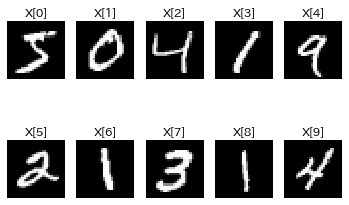

In [7]:
# 画像表示
def show_images(X):
    COLUMN = 5
    ROW = (len(X) - 1) // COLUMN + 1

    fig = plt.figure()

    for i in range(len(X)):
        sub = fig.add_subplot(ROW, COLUMN, i + 1)
        sub.axis('off')
        sub.set_title('X[{}]'.format(i))
        plt.imshow(X[i][0], cmap='gray')

    plt.show()

# 最初の10件を表示
show_images(TX[0:10])

## Section3 Step2. ニューラルネットワークの構造

In [8]:
# (学習に再現性をもたせるためにシードを固定しています。本来は不要です)
np.random.seed(0)

W1 = np.random.randn( 32,  1, 5, 5)   * math.sqrt(2 / ( 1 * 5 * 5))
W2 = np.random.randn( 64, 32, 5, 5)   * math.sqrt(2 / (32 * 5 * 5))
W3 = np.random.randn(200, 64 * 7 * 7) * math.sqrt(2 / (64 * 7 * 7))
W4 = np.random.randn( 10, 200)        * math.sqrt(2 / 200)
b1 = np.zeros(32)
b2 = np.zeros(64)
b3 = np.zeros(200)
b4 = np.zeros(10)

## Section3 Step3. 順伝播

In [9]:
# 畳み込み後の特徴マップのサイズの計算
def output_size(input_size, filter_size, stride_size=1, padding_size=0):
    return (input_size - filter_size + 2 * padding_size) // stride_size + 1

# im形式からcol形式へ変換
# -----------------------
#
# im: (画像数 x チャンネル x 高さ x 幅) の形をした変換前画像
# fh: フィルタの高さ
# fw: フィルタの幅
# s: ストライド
# p: パディング
#
# 戻り値: (特徴マップの縦横サイズ x フィルタのサイズ) の形をした行列
def im2col(im, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = im.shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ゼロパディング
    if p > 0:
        im = np.pad(im, [(0,0), (0,0), (p,p), (p,p)], mode='constant')

    # im形式からcol形式へコピー
    col = np.zeros([N, fh * fw, IC, OH, OW])
    for h in range(fh):
        for w in range(fw):
            col[:, h*fw+w] = im[:, :, h:h+(OH*s):s, w:w+(OW*s):s]

    return col.transpose(0, 3, 4, 2, 1).reshape(N * OH * OW, IC * fh * fw)

In [10]:
# 畳み込み
def convolve(X, W, b, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    K, KC, FH, FW = W.shape
    OH, OW = output_size(IH, FH, s, p), output_size(IW, FW, s, p)

    # 行列積で計算できるようにXとWを変形
    X = im2col(X, FH, FW, s, p)
    W = W.reshape(K, KC * FH * FW).T

    # 畳み込みの計算
    Z = np.dot(X, W) + b

    # 画像数 x チャンネル x 高さ x 幅の並びに戻す
    return Z.reshape(N, OH, OW, K).transpose(0, 3, 1, 2)

In [11]:
# ReLU関数
def relu(X):
    return np.maximum(0, X)

In [12]:
# Max Pooling
def max_pooling(X, fh, fw, s):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    OH, OW = output_size(IH, fh, s), output_size(IW, fw, s)

    # 最大値を選びやすいように形を変更
    X = im2col(X, fh, fw, s).reshape(N * OH * OW * IC, fh * fw)

    # 最大値とそのインデックスを計算
    P  = X.max(axis=1)
    PI = X.argmax(axis=1)

    return P.reshape(N, OH, OW, IC).transpose(0, 3, 1, 2), PI

In [13]:
# Softmax関数
def softmax(X):
    # 最大値を各要素から引いてexpの計算によるオーバーフローを防ぐ
    N = X.shape[0]
    X = X - X.max(axis=1).reshape(N, -1)

    # Softmax関数の計算
    return np.exp(X) / np.exp(X).sum(axis=1).reshape(N, -1)

In [14]:
# 順伝播
def forward(X0):
    # 畳み込み層1
    Z1 = convolve(X0, W1, b1, s=1, p=2)
    A1 = relu(Z1)
    X1, PI1 = max_pooling(A1, fh=2, fw=2, s=2)

    # 畳み込み層2
    Z2 = convolve(X1, W2, b2, s=1, p=2)
    A2 = relu(Z2)
    X2, PI2 = max_pooling(A2, fh=2, fw=2, s=2)

    # 1列に展開
    N = X2.shape[0]
    X2 = X2.reshape(N, -1)

    # 全結合層
    Z3 = np.dot(X2, W3.T) + b3
    X3 = relu(Z3)

    # 出力層
    Z4 = np.dot(X3, W4.T) + b4
    X4 = softmax(Z4)

    return Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4

## Section3 Step4. 逆伝播

In [15]:
# ReLUの微分
def drelu(x):
    return np.where(x > 0, 1, 0)

In [16]:
# 出力層のデルタ
def delta_output(T, Y):
    return -T + Y

In [17]:
# 隠れ層のデルタ
def delta_hidden(Z, D, W):
    return drelu(Z) * np.dot(D, W)

In [18]:
# col形式からim形式へ変換
# -----------------------
#
# col: col形式のデータ
# im_shape: im形式に戻した時の (画像数 x チャンネル x 高さ x 幅) のサイズを指定
# fh: フィルタの高さ
# fw: フィルタの幅
# s: ストライド
# p: パディング
#
# 戻り値: im_shapeに指定したサイズの形をした行列
def col2im(col, im_shape, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップの縦横サイズ
    N, IC, IH, IW = im_shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ストライドとパディングを考慮してim形式用にメモリを確保
    im = np.zeros([N, IC, IH + 2 * p + s - 1, IW + 2 * p + s - 1])

    # col形式からim形式へ戻す。重複した要素は足す
    col = col.reshape(N, OH, OW, IC, fh * fw).transpose(0, 4, 3, 1, 2)
    for h in range(fh):
        for w in range(fw):
            im[:, :, h:h+(OH*s):s, w:w+(OW*s):s] += col[:, h*fw+w]

    # パディング部分は不要なので切り捨てて返す
    return im[:, :, p:IH+p, p:IW+p]

In [20]:
# 畳み込み層のデルタ
def delta_conv(P, D, W, s, p):
    N, DC, DH, DW = D.shape
    K, KC, FH, FW = W.shape

    # 行列を適切に変形してcol形式を作る
    D = D.transpose(0, 2, 3, 1).reshape(N * DH * DW, DC)
    W = W.reshape(K, KC * FH * FW)
    col_D = np.dot(D, W)

    # col形式からim形式に戻してデルタを計算
    return drelu(P) * col2im(col_D, P.shape, FH, FW, s, p)

In [21]:
# MaxPoolingの逆伝播
def backward_max_pooling(im_shape, PI, D, fh, fw, s):
    N, C, H, W = im_shape
    col_D = np.zeros(N * C * H * W).reshape(-1, fh * fw)
    col_D[np.arange(PI.size), PI] = D.flatten()
    return col2im(col_D, im_shape, fh, fw, s)

In [22]:
# 逆伝播
def backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1):
    D4 = delta_output(Y, X4)
    D3 = delta_hidden(Z3, D4, W4)

    D2 = delta_hidden(X2, D3, W3)
    D2 = backward_max_pooling(Z2.shape, PI2, D2, fh=2, fw=2, s=2)

    D1 = delta_conv(X1, D2, W2, s=1, p=2)
    D1 = backward_max_pooling(Z1.shape, PI1, D1, fh=2, fw=2, s=2)

## Section3 Step5. 学習

In [32]:
# 目的関数の重みでの微分
def dweight(D, X):
    return np.dot(D.T, X)

# 目的関数のバイアスでの微分
def dbias(D):
    return D.sum(axis=0)

In [33]:
# 目的関数のフィルタ重みでの微分
def dfilter_weight(X, D, weight_shape):
    K, KC, FH, FW = weight_shape
    N, DC, DH, DW = D.shape

    D = D.transpose(1, 0, 2, 3).reshape(DC, N * DH * DW)
    col_X = im2col(X, FH, FW, 1, 2)
    return np.dot(D, col_X).reshape(K, KC, FH, FW)

# 目的関数のフィルタバイアスでの微分
def dfilter_bias(D):
    N, C, H, W = D.shape
    return D.transpose(1, 0, 2, 3).reshape(C, N * H * W).sum(axis=1)

In [34]:
# 学習率
ETA = 1e-4

In [35]:
# パラメータ更新
def update_parameters(D4, X3, D3, X2, D2, X1, D1, X0):
    global W4, W3, W2, W1, b4, b3, b2, b1

    W4 = W4 - ETA * dweight(D4, X3)
    W3 = W3 - ETA * dweight(D3, X2)
    W2 = W2 - ETA * dfilter_weight(X1, D2, W2.shape)
    W1 = W1 - ETA * dfilter_weight(X0, D1, W1.shape)

    b4 = b4 - ETA * dbias(D4)
    b3 = b3 - ETA * dbias(D3)
    b2 = b2 - ETA * dfilter_bias(D2)
    b1 = b1 - ETA * dfilter_bias(D1)

In [36]:
# 学習
def train(X0, Y):
    Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4 = forward(X0)

    D4, D3, D2, D1 = backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1)

    update_parameters(D4, X3, D3, X2, D2, X1, D1, X0)

In [37]:
# エポック数
EPOCH = 5

In [38]:
# 予測
def predict(X):
    return forward(X)[-1]

# クロスエントロピー関数
def E(T, X):
    return -(T * np.log(predict(X) + 1e-5)).sum()

In [39]:
# ミニバッチ数
BATCH = 100

for epoch in range(1, EPOCH + 1):
    # ミニバッチ学習用にランダムなインデックスを取得
    p = np.random.permutation(len(TX))

    # ミニバッチの数分だけデータを取り出して学習
    for i in range(math.ceil(len(TX) / BATCH)):
        indice = p[i*BATCH:(i+1)*BATCH]
        X0 = TX[indice]
        Y  = TY[indice]

        train(X0, Y)

        # ログを残す
        if i % 10 == 0:
            error = E(Y, X0)
            log = '誤差: {:8.4f} ({:2d}エポック {:3d}バッチ目)'
            print(log.format(error, epoch, i))


TypeError: cannot unpack non-iterable NoneType object

（上記のセルでの実行だとエラーになるので、）ここまでのロジックをまとめて実行する

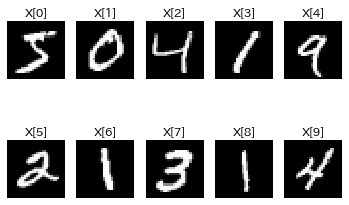

誤差: 232.6482 ( 1エポック   0バッチ目)
誤差: 180.1757 ( 1エポック  10バッチ目)
誤差: 150.5037 ( 1エポック  20バッチ目)
誤差: 124.0823 ( 1エポック  30バッチ目)
誤差: 103.7403 ( 1エポック  40バッチ目)
誤差: 105.7615 ( 1エポック  50バッチ目)
誤差:  84.2429 ( 1エポック  60バッチ目)
誤差:  74.6895 ( 1エポック  70バッチ目)
誤差:  63.5872 ( 1エポック  80バッチ目)
誤差:  59.2054 ( 1エポック  90バッチ目)
誤差:  62.4430 ( 1エポック 100バッチ目)
誤差:  58.2661 ( 1エポック 110バッチ目)
誤差:  62.6979 ( 1エポック 120バッチ目)
誤差:  47.0405 ( 1エポック 130バッチ目)
誤差:  42.0358 ( 1エポック 140バッチ目)
誤差:  37.1723 ( 1エポック 150バッチ目)
誤差:  61.6582 ( 1エポック 160バッチ目)
誤差:  49.3526 ( 1エポック 170バッチ目)
誤差:  33.4987 ( 1エポック 180バッチ目)
誤差:  50.9359 ( 1エポック 190バッチ目)
誤差:  28.7485 ( 1エポック 200バッチ目)
誤差:  48.0901 ( 1エポック 210バッチ目)
誤差:  23.6336 ( 1エポック 220バッチ目)
誤差:  42.2593 ( 1エポック 230バッチ目)
誤差:  25.3201 ( 1エポック 240バッチ目)
誤差:  34.5606 ( 1エポック 250バッチ目)
誤差:  30.4065 ( 1エポック 260バッチ目)
誤差:  29.5481 ( 1エポック 270バッチ目)
誤差:  29.5034 ( 1エポック 280バッチ目)
誤差:  33.7672 ( 1エポック 290バッチ目)
誤差:  26.2860 ( 1エポック 300バッチ目)
誤差:  32.8877 ( 1エポック 310バッチ目)
誤差:  22.2216 ( 1エポック 320バッチ目)
誤差:  34.31

誤差:   8.2387 ( 5エポック 340バッチ目)
誤差:  13.6277 ( 5エポック 350バッチ目)
誤差:   6.5922 ( 5エポック 360バッチ目)
誤差:   4.4622 ( 5エポック 370バッチ目)
誤差:   9.3815 ( 5エポック 380バッチ目)
誤差:  12.0712 ( 5エポック 390バッチ目)
誤差:   9.4624 ( 5エポック 400バッチ目)
誤差:   8.0624 ( 5エポック 410バッチ目)
誤差:   8.7486 ( 5エポック 420バッチ目)
誤差:   5.5758 ( 5エポック 430バッチ目)
誤差:  14.9112 ( 5エポック 440バッチ目)
誤差:   6.2464 ( 5エポック 450バッチ目)
誤差:   7.1929 ( 5エポック 460バッチ目)
誤差:   4.9157 ( 5エポック 470バッチ目)
誤差:  13.1214 ( 5エポック 480バッチ目)
誤差:  11.2901 ( 5エポック 490バッチ目)
誤差:   5.4146 ( 5エポック 500バッチ目)
誤差:   6.2514 ( 5エポック 510バッチ目)
誤差:   5.5781 ( 5エポック 520バッチ目)
誤差:   8.6780 ( 5エポック 530バッチ目)
誤差:   7.1779 ( 5エポック 540バッチ目)
誤差:   8.2062 ( 5エポック 550バッチ目)
誤差:   6.0487 ( 5エポック 560バッチ目)
誤差:  11.8528 ( 5エポック 570バッチ目)
誤差:  16.7475 ( 5エポック 580バッチ目)
誤差:   7.1686 ( 5エポック 590バッチ目)


In [40]:
import numpy as np
import math
import os.path
import urllib.request
import gzip
import matplotlib.pyplot as plt

# MNISTデータセットをダウンロード
def download_mnist_dataset(url):
    filename = './' + os.path.basename(url)
    if os.path.isfile(filename):
        return

    buf = urllib.request.urlopen(url).read()
    with open(filename, mode='wb') as f:
        f.write(buf)

BASE_URL = 'http://yann.lecun.com/exdb/mnist/'
filenames = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz'
]
[download_mnist_dataset(BASE_URL + filename) for filename in filenames]

# MNISTデータセット読み込み
def load_file(filename, offset):
    with gzip.open('./' + filename + '.gz', 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

# 学習データを読み込む
TX = load_file('train-images-idx3-ubyte', offset=16)
TY = load_file('train-labels-idx1-ubyte', offset=8)

def convertX(X):
    return X.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

TX = convertX(TX)

def convertY(Y):
    return np.eye(10)[Y]

TY = convertY(TY)

# 画像表示
def show_images(X):
    COLUMN = 5
    ROW = (len(X) - 1) // COLUMN + 1

    fig = plt.figure()

    for i in range(len(X)):
        sub = fig.add_subplot(ROW, COLUMN, i + 1)
        sub.axis('off')
        sub.set_title('X[{}]'.format(i))
        plt.imshow(X[i][0], cmap='gray')

    plt.show()

# 最初の10件を表示
show_images(TX[0:10])

# (学習に再現性をもたせるためにシードを固定しています。本来は不要です)
np.random.seed(0)

W1 = np.random.randn( 32,  1, 5, 5)   * math.sqrt(2 / ( 1 * 5 * 5))
W2 = np.random.randn( 64, 32, 5, 5)   * math.sqrt(2 / (32 * 5 * 5))
W3 = np.random.randn(200, 64 * 7 * 7) * math.sqrt(2 / (64 * 7 * 7))
W4 = np.random.randn( 10, 200)        * math.sqrt(2 / 200)
b1 = np.zeros(32)
b2 = np.zeros(64)
b3 = np.zeros(200)
b4 = np.zeros(10)

# 畳み込み後の特徴マップのサイズの計算
def output_size(input_size, filter_size, stride_size=1, padding_size=0):
    return (input_size - filter_size + 2 * padding_size) // stride_size + 1

# im形式からcol形式へ変換
# -----------------------
#
# im: (画像数 x チャンネル x 高さ x 幅) の形をした変換前画像
# fh: フィルタの高さ
# fw: フィルタの幅
# s: ストライド
# p: パディング
#
# 戻り値: (特徴マップの縦横サイズ x フィルタのサイズ) の形をした行列
def im2col(im, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = im.shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ゼロパディング
    if p > 0:
        im = np.pad(im, [(0,0), (0,0), (p,p), (p,p)], mode='constant')

    # im形式からcol形式へコピー
    col = np.zeros([N, fh * fw, IC, OH, OW])
    for h in range(fh):
        for w in range(fw):
            col[:, h*fw+w] = im[:, :, h:h+(OH*s):s, w:w+(OW*s):s]

    return col.transpose(0, 3, 4, 2, 1).reshape(N * OH * OW, IC * fh * fw)

# 畳み込み
def convolve(X, W, b, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    K, KC, FH, FW = W.shape
    OH, OW = output_size(IH, FH, s, p), output_size(IW, FW, s, p)

    # 行列積で計算できるようにXとWを変形
    X = im2col(X, FH, FW, s, p)
    W = W.reshape(K, KC * FH * FW).T

    # 畳み込みの計算
    Z = np.dot(X, W) + b

    # 画像数 x チャンネル x 高さ x 幅の並びに戻す
    return Z.reshape(N, OH, OW, K).transpose(0, 3, 1, 2)

# ReLU関数
def relu(X):
    return np.maximum(0, X)

# Max Pooling
def max_pooling(X, fh, fw, s):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    OH, OW = output_size(IH, fh, s), output_size(IW, fw, s)

    # 最大値を選びやすいように形を変更
    X = im2col(X, fh, fw, s).reshape(N * OH * OW * IC, fh * fw)

    # 最大値とそのインデックスを計算
    P  = X.max(axis=1)
    PI = X.argmax(axis=1)

    return P.reshape(N, OH, OW, IC).transpose(0, 3, 1, 2), PI

# Softmax関数
def softmax(X):
    # 最大値を各要素から引いてexpの計算によるオーバーフローを防ぐ
    N = X.shape[0]
    X = X - X.max(axis=1).reshape(N, -1)

    # Softmax関数の計算
    return np.exp(X) / np.exp(X).sum(axis=1).reshape(N, -1)

# 順伝播
def forward(X0):
    # 畳み込み層1
    Z1 = convolve(X0, W1, b1, s=1, p=2)
    A1 = relu(Z1)
    X1, PI1 = max_pooling(A1, fh=2, fw=2, s=2)

    # 畳み込み層2
    Z2 = convolve(X1, W2, b2, s=1, p=2)
    A2 = relu(Z2)
    X2, PI2 = max_pooling(A2, fh=2, fw=2, s=2)

    # 1列に展開
    N = X2.shape[0]
    X2 = X2.reshape(N, -1)

    # 全結合層
    Z3 = np.dot(X2, W3.T) + b3
    X3 = relu(Z3)

    # 出力層
    Z4 = np.dot(X3, W4.T) + b4
    X4 = softmax(Z4)

    return Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4

# ReLUの微分
def drelu(x):
    return np.where(x > 0, 1, 0)

# 出力層のデルタ
def delta_output(T, Y):
    return -T + Y

# 隠れ層のデルタ
def delta_hidden(Z, D, W):
    return drelu(Z) * np.dot(D, W)

# col形式からim形式へ変換
# -----------------------
#
# col: col形式のデータ
# im_shape: im形式に戻した時の (画像数 x チャンネル x 高さ x 幅) のサイズを指定
# fh: フィルタの高さ
# fw: フィルタの幅
# s: ストライド
# p: パディング
#
# 戻り値: im_shapeに指定したサイズの形をした行列
def col2im(col, im_shape, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップの縦横サイズ
    N, IC, IH, IW = im_shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ストライドとパディングを考慮してim形式用にメモリを確保
    im = np.zeros([N, IC, IH + 2 * p + s - 1, IW + 2 * p + s - 1])

    # col形式からim形式へ戻す。重複した要素は足す
    col = col.reshape(N, OH, OW, IC, fh * fw).transpose(0, 4, 3, 1, 2)
    for h in range(fh):
        for w in range(fw):
            im[:, :, h:h+(OH*s):s, w:w+(OW*s):s] += col[:, h*fw+w]

    # パディング部分は不要なので切り捨てて返す
    return im[:, :, p:IH+p, p:IW+p]

# 畳み込み層のデルタ
def delta_conv(P, D, W, s, p):
    N, DC, DH, DW = D.shape
    K, KC, FH, FW = W.shape

    # 行列を適切に変形してcol形式を作る
    D = D.transpose(0, 2, 3, 1).reshape(N * DH * DW, DC)
    W = W.reshape(K, KC * FH * FW)
    col_D = np.dot(D, W)

    # col形式からim形式に戻してデルタを計算
    return drelu(P) * col2im(col_D, P.shape, FH, FW, s, p)

# MaxPoolingの逆伝播
def backward_max_pooling(im_shape, PI, D, fh, fw, s):
    N, C, H, W = im_shape
    col_D = np.zeros(N * C * H * W).reshape(-1, fh * fw)
    col_D[np.arange(PI.size), PI] = D.flatten()
    return col2im(col_D, im_shape, fh, fw, s)

# 逆伝播
def backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1):
    D4 = delta_output(Y, X4)
    D3 = delta_hidden(Z3, D4, W4)

    D2 = delta_hidden(X2, D3, W3)
    D2 = backward_max_pooling(Z2.shape, PI2, D2, fh=2, fw=2, s=2)

    D1 = delta_conv(X1, D2, W2, s=1, p=2)
    D1 = backward_max_pooling(Z1.shape, PI1, D1, fh=2, fw=2, s=2)

    return D4, D3, D2, D1

# 目的関数の重みでの微分
def dweight(D, X):
    return np.dot(D.T, X)

# 目的関数のバイアスでの微分
def dbias(D):
    return D.sum(axis=0)

# 目的関数のフィルタ重みでの微分
def dfilter_weight(X, D, weight_shape):
    K, KC, FH, FW = weight_shape
    N, DC, DH, DW = D.shape

    D = D.transpose(1, 0, 2, 3).reshape(DC, N * DH * DW)
    col_X = im2col(X, FH, FW, 1, 2)
    return np.dot(D, col_X).reshape(K, KC, FH, FW)

# 目的関数のフィルタバイアスでの微分
def dfilter_bias(D):
    N, C, H, W = D.shape
    return D.transpose(1, 0, 2, 3).reshape(C, N * H * W).sum(axis=1)

# 学習率
ETA = 1e-4

# パラメータ更新
def update_parameters(D4, X3, D3, X2, D2, X1, D1, X0):
    global W4, W3, W2, W1, b4, b3, b2, b1

    W4 = W4 - ETA * dweight(D4, X3)
    W3 = W3 - ETA * dweight(D3, X2)
    W2 = W2 - ETA * dfilter_weight(X1, D2, W2.shape)
    W1 = W1 - ETA * dfilter_weight(X0, D1, W1.shape)

    b4 = b4 - ETA * dbias(D4)
    b3 = b3 - ETA * dbias(D3)
    b2 = b2 - ETA * dfilter_bias(D2)
    b1 = b1 - ETA * dfilter_bias(D1)

# 学習
def train(X0, Y):
    Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4 = forward(X0)

    D4, D3, D2, D1 = backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1)

    update_parameters(D4, X3, D3, X2, D2, X1, D1, X0)

# エポック数
EPOCH = 5

# 予測
def predict(X):
    return forward(X)[-1]

# クロスエントロピー関数
def E(T, X):
    return -(T * np.log(predict(X) + 1e-5)).sum()

# ミニバッチ数
BATCH = 100

for epoch in range(1, EPOCH + 1):
    # ミニバッチ学習用にランダムなインデックスを取得
    p = np.random.permutation(len(TX))

    # ミニバッチの数分だけデータを取り出して学習
    for i in range(math.ceil(len(TX) / BATCH)):
        indice = p[i*BATCH:(i+1)*BATCH]
        X0 = TX[indice]
        Y  = TY[indice]

        train(X0, Y)

        # ログを残す
        if i % 10 == 0:
            error = E(Y, X0)
            log = '誤差: {:8.4f} ({:2d}エポック {:3d}バッチ目)'
            print(log.format(error, epoch, i))

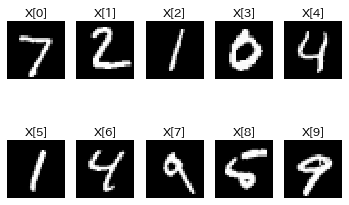

In [41]:
testX = load_file('t10k-images-idx3-ubyte', offset=16)
testX = convertX(testX)

# テストデータの最初の10件を表示
show_images(testX[0:10])

In [42]:
# 分類
def classify(X):
    return np.argmax(predict(X), axis=1)

classify(testX[0:10])

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])